In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [3]:
df = pd.read_csv("./HEART.csv")

In [4]:
df.head()

,Status,DeathCause,AgeCHDdiag,Sex,AgeAtStart,Height,Weight,Diastolic,Systolic,MRW,Smoking,AgeAtDeath,Cholesterol,Chol_Status,BP_Status,Weight_Status,Smoking_Status
0,Dead,Other,NaN,Female,29,62.50,140.0,78,124,121.0,0.0,55.0,NaN,NaN,Normal,Overweight,Non-smoker
1,Dead,Cancer,NaN,Female,41,59.75,194.0,92,144,183.0,0.0,57.0,181.0,Desirable,High,Overweight,Non-smoker
2,Alive,NaN,NaN,Female,57,62.25,132.0,90,170,114.0,10.0,NaN,250.0,High,High,Overweight,Moderate (6-15)
3,Alive,NaN,NaN,Female,39,65.75,158.0,80,128,123.0,0.0,NaN,242.0,High,Normal,Overweight,Non-smoker
4,Alive,NaN,NaN,Male,42,66.00,156.0,76,110,116.0,20.0,NaN,281.0,High,Optimal,Overweight,Heavy (16-25)


In [5]:
df.columns

Index(['Status', 'DeathCause', 'AgeCHDdiag', 'Sex', 'AgeAtStart', 'Height',
       'Weight', 'Diastolic', 'Systolic', 'MRW', 'Smoking', 'AgeAtDeath',
       'Cholesterol', 'Chol_Status', 'BP_Status', 'Weight_Status',
       'Smoking_Status'],
      dtype='object')

In [6]:
df.isna().sum()

Status               0
DeathCause        3218
AgeCHDdiag        3760
Sex                  0
AgeAtStart           0
Height               6
Weight               6
Diastolic            0
Systolic             0
MRW                  6
Smoking             36
AgeAtDeath        3218
Cholesterol        152
Chol_Status        152
BP_Status            0
Weight_Status        6
Smoking_Status      36
dtype: int64

In [7]:
df['Chol_Status'].value_counts()

Chol_Status
Borderline    1861
High          1791
Desirable     1405
Name: count, dtype: int64

In [8]:

# Impute missing values for Cholesterol based on subgroups
column_to_impute = 'Cholesterol'

# Define the relevant grouping columns
grouping_columns = ['Sex', 'AgeAtStart', 'Smoking_Status']

# Create a mask for missing values
missing_values_mask = df[column_to_impute].isnull()

# Group by the relevant columns and calculate the mean for each group
imputation_values = df.groupby(grouping_columns)[column_to_impute].mean()

# Use the calculated mean to fill missing values based on the group
df.loc[missing_values_mask, column_to_impute] = df.loc[missing_values_mask, grouping_columns].apply(
    lambda row: imputation_values.get((row['Sex'], row['AgeAtStart'], row['Smoking_Status']), None),
    axis=1
)

# If there are still NaN values, fill them with the overall mean
overall_mean = df[column_to_impute].mean()
df[column_to_impute].fillna(overall_mean, inplace=True)

In [9]:
df['Cholesterol'].isna().sum()

0

In [10]:
# Impute missing values for Chol_Status with the most frequent category (mode)
column_to_impute = 'Chol_Status'

# Find the most frequent category
most_frequent_category = df[column_to_impute].mode().iloc[0]

# Impute missing values with the most frequent category
df[column_to_impute] = df[column_to_impute].fillna(most_frequent_category)


In [11]:
df['Chol_Status'].isna().sum()

0

In [12]:
# Impute missing values for "Smoking" based on other relevant columns
# You can use a simple strategy like filling with the mode or median
df['Smoking'].fillna(df['Smoking'].mode().iloc[0], inplace=True)

# Impute missing values for "Smoking_Status" based on the imputed "Smoking" values
df['Smoking_Status'].fillna(df['Smoking'], inplace=True)

In [13]:
df.isna().sum()

Status               0
DeathCause        3218
AgeCHDdiag        3760
Sex                  0
AgeAtStart           0
Height               6
Weight               6
Diastolic            0
Systolic             0
MRW                  6
Smoking              0
AgeAtDeath        3218
Cholesterol          0
Chol_Status          0
BP_Status            0
Weight_Status        6
Smoking_Status       0
dtype: int64

In [14]:
# Impute based on subgroup means
subgroup_means = df.groupby(['Sex', 'Smoking_Status'])['AgeCHDdiag'].mean()
df['AgeCHDdiag'] = df.apply(
    lambda row: subgroup_means.loc[row['Sex'], row['Smoking_Status']] if pd.isnull(row['AgeCHDdiag']) else row['AgeCHDdiag'],
    axis=1
)


In [15]:
df.isna().sum()

Status               0
DeathCause        3218
AgeCHDdiag           0
Sex                  0
AgeAtStart           0
Height               6
Weight               6
Diastolic            0
Systolic             0
MRW                  6
Smoking              0
AgeAtDeath        3218
Cholesterol          0
Chol_Status          0
BP_Status            0
Weight_Status        6
Smoking_Status       0
dtype: int64

In [16]:
# For these numerical columns, we can impute missing values with the mean or median of the respective columns
columns_to_impute = ['Height', 'Weight', 'MRW']
for column in columns_to_impute:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)


In [17]:
# For the "Weight_Status" column, if it's a categorical variable, we can impute missing values with the mode (most frequent category).
df['Weight_Status'].fillna(df['Weight_Status'].mode().iloc[0], inplace=True)


In [18]:
df['DeathCause'].fillna('Not Applicable', inplace=True)


In [19]:
# Similar to "DeathCause," if "AgeAtDeath" is missing for individuals marked as "Alive," 
# we might consider filling those missing values with a placeholder or a specific value indicating 
# that the individual is still alive.
df.loc[df['Status'] == 'Alive', 'AgeAtDeath'] = -1  # You can choose an appropriate placeholder value


In [20]:
df.isna().sum()

Status            0
DeathCause        0
AgeCHDdiag        0
Sex               0
AgeAtStart        0
Height            0
Weight            0
Diastolic         0
Systolic          0
MRW               0
Smoking           0
AgeAtDeath        0
Cholesterol       0
Chol_Status       0
BP_Status         0
Weight_Status     0
Smoking_Status    0
dtype: int64

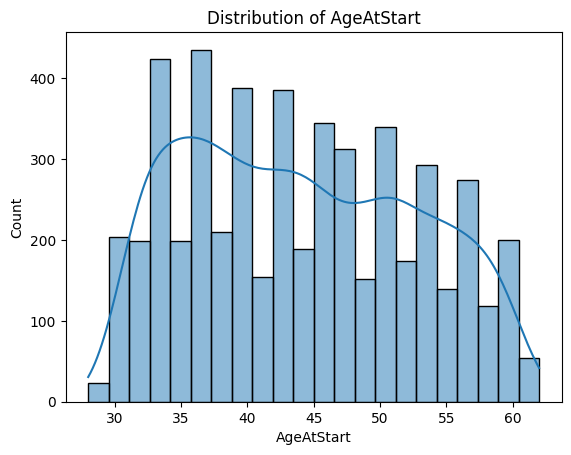

In [21]:
# Summary Statistics: Calculate mean, median, standard deviation, min, max, and other relevant statistics for numerical features.
# Distribution Plots: Visualize the distribution of numerical features using histograms or kernel density plots.

# Example for AgeAtStart
sns.histplot(df['AgeAtStart'], kde=True)
plt.title('Distribution of AgeAtStart')
plt.show()


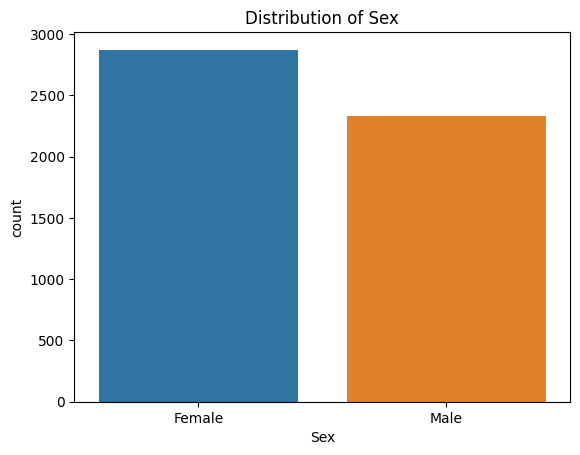

In [22]:
# Count Plots: Visualize the distribution of categorical features using count plots.
sns.countplot(x='Sex', data=df)
plt.title('Distribution of Sex')
plt.show()


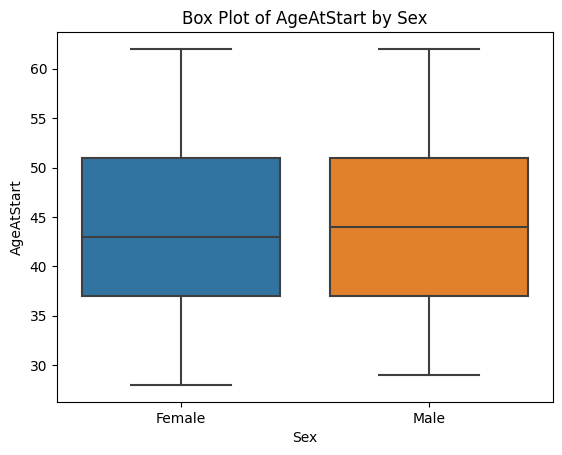

In [23]:
# Example for AgeAtStart and Sex
# Box Plots: Investigate the relationship between a numerical feature and a categorical feature.
sns.boxplot(x='Sex', y='AgeAtStart', data=df)
plt.title('Box Plot of AgeAtStart by Sex')
plt.show()


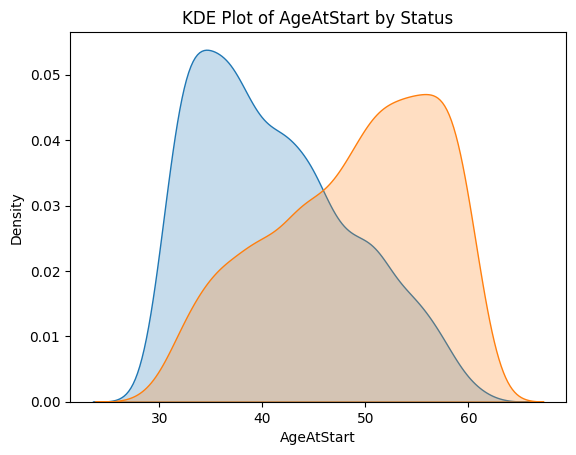

In [24]:
# KDE plot by Status for AgeAtStart
# Comparing target variable distributions of features between different target classes.
sns.kdeplot(df[df['Status'] == 'Alive']['AgeAtStart'], label='Alive', shade=True)
sns.kdeplot(df[df['Status'] == 'Dead']['AgeAtStart'], label='Dead', shade=True)
plt.title('KDE Plot of AgeAtStart by Status')
plt.show()

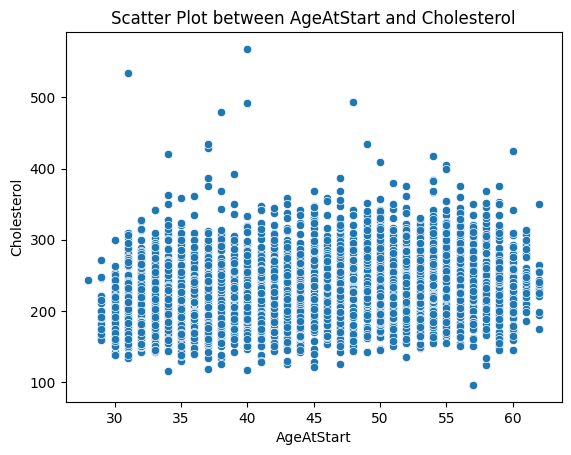

In [25]:
# Example for a scatter plot between AgeAtStart and Cholesterol
# Explore relationships between pairs of features.
sns.scatterplot(x='AgeAtStart', y='Cholesterol', data=df)
plt.title('Scatter Plot between AgeAtStart and Cholesterol')
plt.show()


In [26]:
df['Status'] = df['Status'].map({'Alive': 0, 'Dead': 1})

In [27]:
# Data Prep

X = df.drop(['Status', 'DeathCause', 'AgeAtDeath'], axis=1)  # Adjust columns as needed
y = df['Status']  # Target variable


In [28]:
# Convert categorical variables into numerical format using one-hot encoding.
X = pd.get_dummies(X)


In [29]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# Scale numerical features to a similar range to improve model convergence.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# Build Neural Network Model
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [32]:
# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))


Epoch 1/10


131/131 [==============================] - 2s 5ms/step - loss: 0.5688 - accuracy: 0.7043 - val_loss: 0.5151 - val_accuracy: 0.7505
Epoch 2/10
131/131 [==============================] - 0s 3ms/step - loss: 0.5252 - accuracy: 0.7413 - val_loss: 0.5062 - val_accuracy: 0.7582
Epoch 3/10
131/131 [==============================] - 0s 3ms/step - loss: 0.5122 - accuracy: 0.7463 - val_loss: 0.5071 - val_accuracy: 0.7620
Epoch 4/10
131/131 [==============================] - 0s 3ms/step - loss: 0.5084 - accuracy: 0.7471 - val_loss: 0.5038 - val_accuracy: 0.7620
Epoch 5/10
131/131 [==============================] - 0s 3ms/step - loss: 0.5023 - accuracy: 0.7547 - val_loss: 0.5067 - val_accuracy: 0.7687
Epoch 6/10
131/131 [==============================] - 0s 3ms/step - loss: 0.5007 - accuracy: 0.7555 - val_loss: 0.5043 - val_accuracy: 0.7678
Epoch 7/10
131/131 [==============================] - 0s 3ms/step - loss: 0.4970 - accuracy: 0.7562 - val_loss: 0.5030 - val_accuracy: 0.7687
Epoc

In [33]:
# Model Evaluation
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


33/33 [==============================] - 0s 2ms/step - loss: 0.5050 - accuracy: 0.7678
Test Loss: 0.5049828290939331, Test Accuracy: 0.767754316329956


In [34]:
# Use the trained model to make predictions.

predictions = model.predict(X_test_scaled)


33/33 [==============================] - 0s 2ms/step


In [35]:
# Convert probabilities to class labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

# Display the predictions alongside the actual labels
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': predicted_labels.flatten(), 'Probability': predictions.flatten()})

print(result_df)

      Actual  Predicted  Probability
468        0          0     0.089027
296        0          0     0.119314
2509       1          1     0.809443
4272       0          0     0.067140
4005       1          0     0.217802
2409       1          1     0.704944
132        0          1     0.598911
848        0          1     0.628012
1183       1          0     0.053204
1117       1          1     0.914387
2098       0          0     0.044295
3930       0          0     0.045001
1321       0          0     0.227122
1697       1          0     0.144232
3048       0          0     0.389755
2518       0          0     0.118569
3668       1          0     0.459427
4977       1          1     0.521716
2829       1          0     0.246070
23         0          0     0.121669
4674       0          0     0.180721
538        1          1     0.711392
79         0          1     0.592954
3080       1          1     0.898185
3362       0          0     0.318907
751        0          0     0.297214
4

In [36]:
# Assuming 'result_df' contains the Actual and Predicted columns
error_rate = sum(result_df['Actual'] != result_df['Predicted']) / len(result_df)

print(f'Error Rate: {error_rate:.2%}')


Error Rate: 23.22%
